# Neural Network to classify healthy and non-healthy Tuberculosis (TB) manifestations with chest X-rays

Install and import necessary dependencies

In [34]:
! pip install torch torchvision scikit-learn --quiet

68296.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

Define device

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing

Funtion to load the dataset

In [37]:
class ChestXRayDataset(Dataset):
    def __init__(self, image_dir, metadata_dir, left_mask_dir, right_mask_dir, transform=None):
        self.image_dir = image_dir
        self.metadata_dir = metadata_dir
        self.left_mask_dir = left_mask_dir
        self.right_mask_dir = right_mask_dir
        self.transform = transform
        
        self.data = []
        self.labels = []
        
        # Images will be resized to 100x100 pixels
        self.image_shape = (100, 100)

        # Initialize images and labels
        self.load_data()

    def load_data(self):
        for img_name in os.listdir(self.image_dir):
            if img_name.endswith('.png'): # Only process PNG files
                try:
                    # Load image
                    img_path = os.path.join(self.image_dir, img_name)

                    # Number of gray levels is 12bits, so we read the image with the original image depth (number of channels)
                    img_array = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

                    # Equalize histogram to improve contrast in images
                    img_array = cv2.equalizeHist(img_array)

                    # Resize image to 100x100 pixels for faster training and less memory usage
                    resized_img = cv2.resize(img_array, self.image_shape)

                    # Load lung masks
                    left_mask_path = os.path.join(self.left_mask_dir, img_name)
                    right_mask_path = os.path.join(self.right_mask_dir, img_name)
                    left_mask = cv2.imread(left_mask_path, cv2.IMREAD_GRAYSCALE)
                    right_mask = cv2.imread(right_mask_path, cv2.IMREAD_GRAYSCALE)

                    # Combine masks
                    combined_mask = cv2.bitwise_or(left_mask, right_mask)
                    combined_mask = cv2.resize(combined_mask, self.image_shape)

                    # Apply mask to image
                    masked_img = cv2.bitwise_and(resized_img, resized_img, mask=combined_mask)

                    # Extract labels from file name suffix
                    #  ‘0’ represents the normal and ‘1’ represents the abnormal lung.
                    label = int(img_name.replace('.png', '')[-1])

                    self.data.append(masked_img)
                    self.labels.append(label) 

                except Exception as e:
                    print(f"Error loading image {img_name}: {e}")

        # Normalize data to range [0, 1] and convert to numpy array
        # Also reshape data to 4D tensor (batch_size, height, width, channels) for PyTorch input 
        self.data = np.array(self.data).reshape(-1, 100, 100, 1) / 4095.0
        self.labels = np.array(self.labels)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

Load the dataset

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ChestXRayDataset(
    image_dir='./data/CXR_png',
    metadata_dir='./data/ClinicalReadings',
    left_mask_dir='./data/ManualMask/leftMask',
    right_mask_dir='./data/ManualMask/rightMask',
    transform=transform
)

print(f"Data shape: {dataset.data.shape}")
print(f"Labels shape: {dataset.labels.shape}")

Data shape: (138, 100, 100, 1)
Labels shape: (138,)


Visualize the first 8 images from the dataset

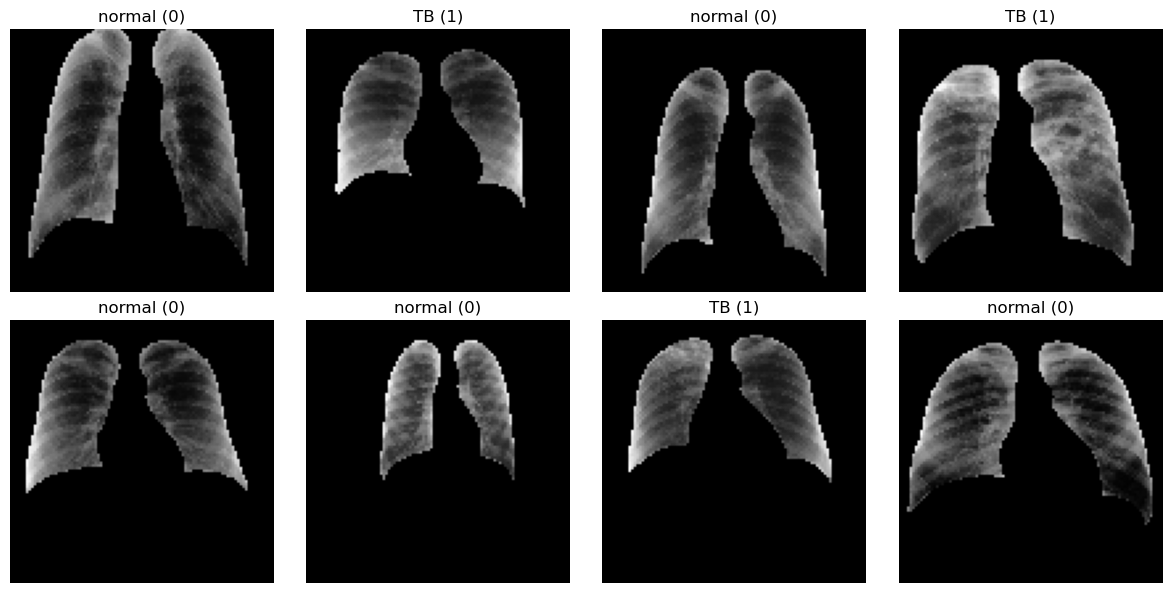

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i in range(8):
    ax = axes[i // 4, i % 4]
    image, label = dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title('TB (1)' if label == 1 else 'normal (0)')
    ax.axis('off')

plt.tight_layout()
plt.show()

Split dataset into training, validation, and testing sets

In [25]:
train_size = int(0.8 * len(dataset)) 
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Creation

In [28]:
import torch
import torch.nn as nn

class TBNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TBNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, x.size(1) * x.size(2))  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

Model parameters

In [32]:
input_size = 100 * 100
hidden_size = 128
output_size = 1  # Binary classification, TB or no-TB

model = TBNet(input_size, hidden_size, output_size)

# Model Training